# Lineage Tracking for Cells in the Mother Machine

In [1]:
%load_ext autoreload
%autoreload 2

from LineageTrack.lineage_tracker import LineageTrack
from LineageTrack.visualiser_zarr import Visualiser
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image, display, HTML
import ast
import pandas as pd
import pickle

### comment out ###
# from jupyterthemes import jtplot
# jtplot.style(theme='oceans16')

This notebook has several main sections:
 - Data preprocessing
 - Tracking step 1: loading cell growth properties from the mother
 - Tracking step 2: running the tracker
 - Accessing the tracking data
 - Visualising the tracking from the cell images

### Data Preprocessing

The cell properties data can be obtained from `skimage.measure.regionprops` on the masked trench images. There is a built-in feature extractor in MMLT. We typically extract from zarr array. More details can be found in a separate notebook `gen_prop_example.ipynb`

In [2]:
### Extracting from TIFF and PNG 
# from LineageTrack.measure_properties import generate_csv
# from joblib import Parallel, delayed

# exp_dir = ".\\Data\\"
# mask_dir = exp_dir + "binary_masks\\"
# channel_image_dir = exp_dir + "trenches\\"
# fov_list = ["000", "001", "002", ...]
# Parallel(n_jobs=-1)(delayed(generate_csv)(f"xy{fov}", mask_dir, channel_image_dir, 3, 
#                                          ".\\Data\\FOV{}\\".format(fov) + "prop\\", 
#                                          30, ['PC', 'mCherry', 'YFP']) 
#                    for fov in fov_list)

In [3]:
### Extracting from zarr
# from LineageTrack.from_zarr import generate_csv
# from joblib import Parallel, delayed

# exp_dir = ".\\Data\\"
# mask_dir = exp_dir + "masks.zarr"
# channel_image_dir = exp_dir + "trenches.zarr"
# generate_csv(mask_dir, channel_image_dir, ".\\prop\\", 3, 30, [0, 1, 2], ['PC', 'mCherry', 'YFP'], step=1)
# # TODO: need to parallelise this

In [4]:
exp_dir = os.getcwd()
mask_dir = exp_dir + "/example/masks_1010.zarr"
channel_image_dir = exp_dir + "/example/1010.zarr"

Load the properties of cells from a directory containing the csv files **only** or load it with paths to every single file

In [5]:
directory = "./example/csv/"    # the example includes the first 13 trenches from Charlie's Phage experiment
exp = LineageTrack.from_path(directory)
print(exp)
display(exp.df.head(1))
# or
# filepath1 = ""
# filepath2 = ""
# ...
# exp = LineageTrack.from_path(filepath1, filepath2, ...)

Looking for data at these locations:
./example/csv/PC_properties.csv
Finished loading the data
(1076, 15)

                Read 1 files
                Channels: ['PC']
                Properties for each cell: ['PC_intensity_max', 'PC_intensity_mean', 'PC_intensity_min', 'PC_intensity_total', 'area', 'centroid-0', 'centroid-1', 'label', 'major_axis_length', 'minor_axis_length', 'orientation', 'time_(mins)', 'trench_id', 'zernike', 'zernike_half']
            


trench_id  time_(mins)  label  area  major_axis_length  minor_axis_length  \
0          0            0      1  1107          68.137871          20.953432   

   centroid-0  centroid-1  orientation  PC_intensity_mean  PC_intensity_max  \
0   55.598915   20.093948    -0.115785         107.390244             232.0   

   PC_intensity_min  PC_intensity_total  \
0              40.0            118881.0   

                                             zernike  \
0  [0.3183098861837963, 3.5415672554881664e-17, 0...   

                                        zernike_half  
0  [[0.3183098861837887, 1.820980731878212e-17, 0...

### Tracking Algorithm: Simulation and Matching

*Currently this algorithm is designed for exponential growth*

Model for cell growing: 
>$L_{t+\Delta t} = L_t \times 2^{(\Delta t / \tau)}$

Adder-Sizer model for one cell of length $L$ and growth $\delta L$ since it is born dividing during a time interval, $\Delta t$: 
> $Pr(y=divide|\theta) = \Phi( L, \delta L | \theta)$
- $\theta$ is the parameters for adder and sizer model
- $\Phi$ is the skewed normal bivariate CDF, here sizer and adder model is independent of each other.
- Assumptions: Division between cells are independent
- The prior is calculated based on this. For multiples cells, the probabilities are multiplied together

In [6]:
# # If you included Zernike by setting descptor=True, check it is loaded correctly
# zer = exp.df['zernike'][0]
# print(type(ast.literal_eval(zer)[0]))

#### STEP 1:
Estimate the growth time constant $\tau$, or the doubling time T, by observing the mother cell in some trenches (they can be the same thing but are measured in different ways here)

User need to select the period, e.g., exponential growth

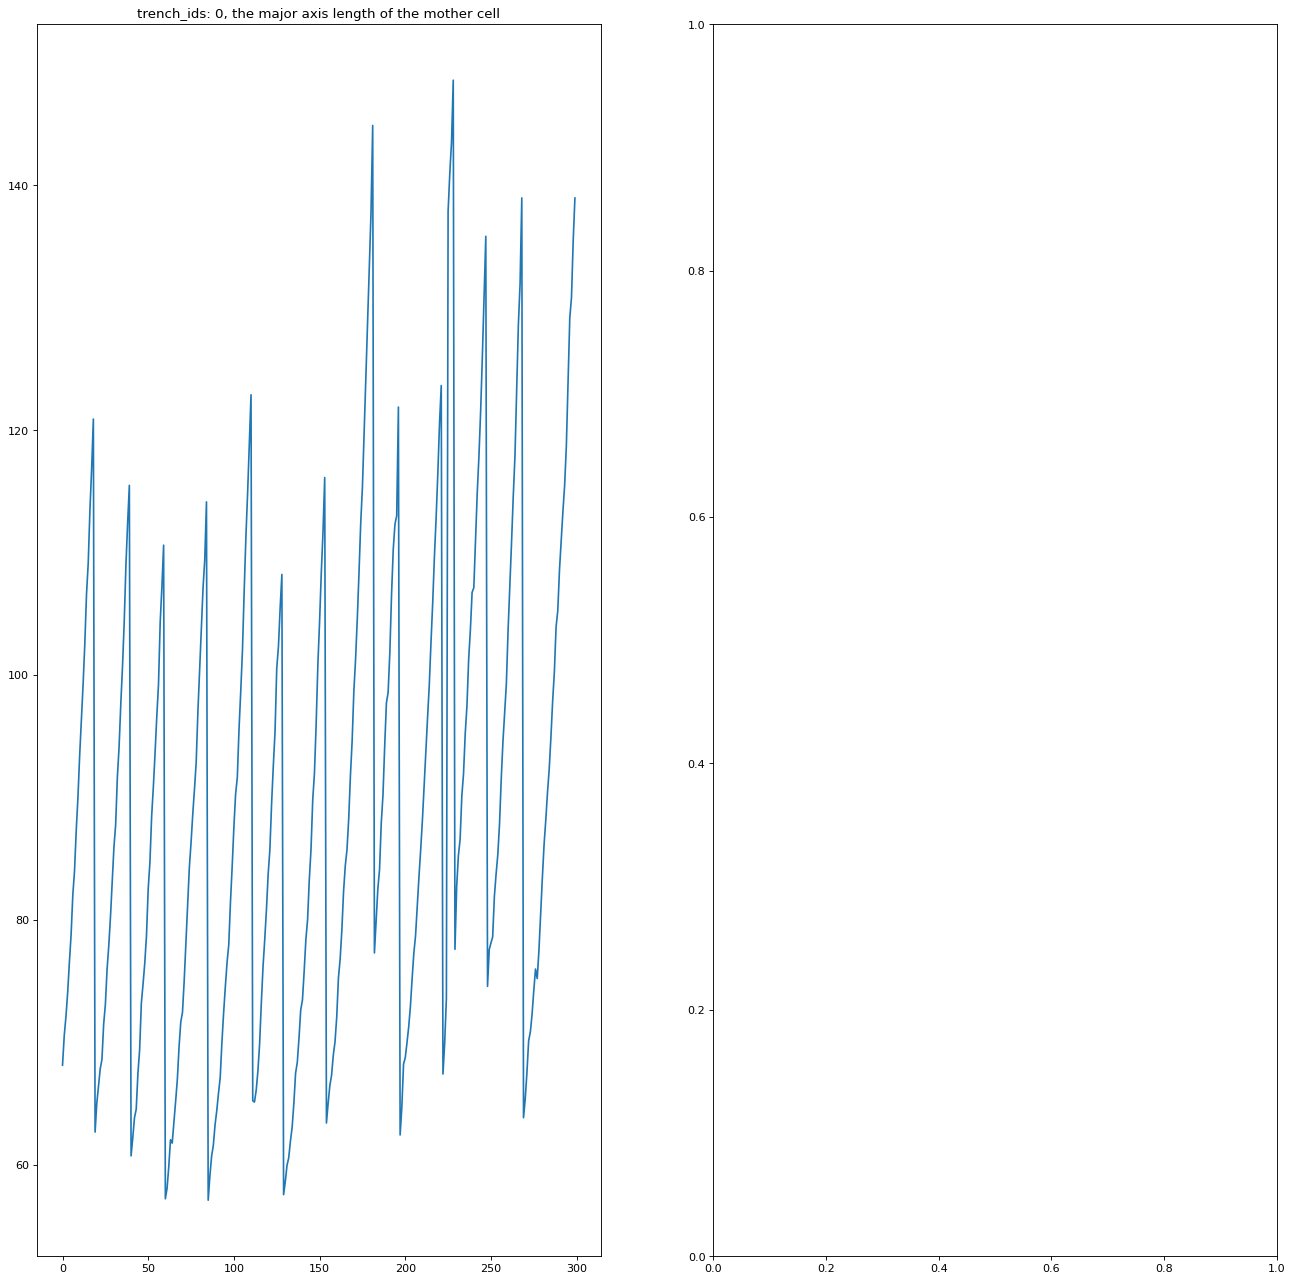

In [7]:
# trench_list = [i for i in range(10)]
trench_list = exp.trenches

m = exp.get_mother_cell_growth(trench_list, plot=True)

Find the division times for trench 1

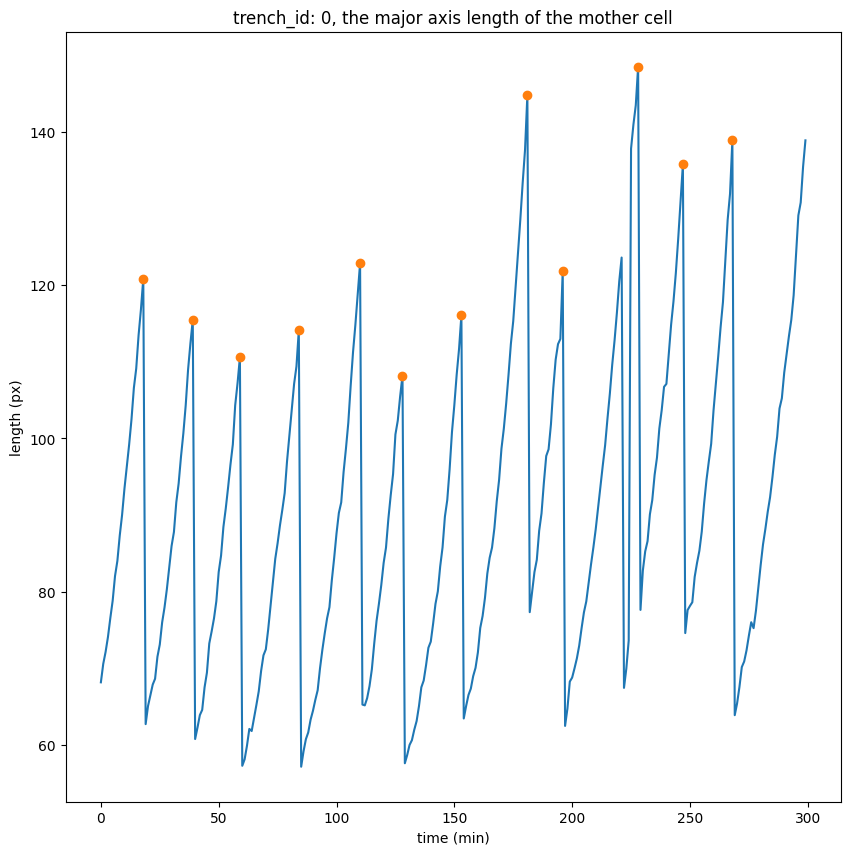

[[ 18.         120.89851379]
 [ 39.         115.48722839]
 [ 59.         110.60189056]
 [ 84.         114.13518524]
 [110.         122.88018799]
 [128.         108.21312714]
 [153.         116.11997223]
 [181.         144.87208557]
 [196.         121.87496185]
 [228.         148.56715393]
 [247.         135.82086182]
 [268.         138.95658875]]


In [8]:
mcell1, idx1 = exp.find_division(trench=0, threshold=1, distance=10, height=70, prominence=20, plot=True)

peaks = [mcell1[1][i, :] for i in idx1]
peaks = np.array(peaks)
print(peaks)

Select the peaks between the exponential growth phase, calculate intervals between division and for each interval, estimate the growth constant

> NOTE: the peak could also be lysis, one way to check is to visualise the mother cell

the slope is estimated to be 0.044504332950194854
the intercept is estimated to be 5.944140549483257


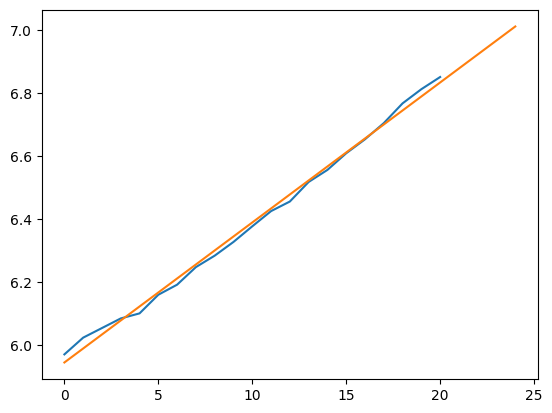

the slope is estimated to be 0.046578797542435456
the intercept is estimated to be 5.8984102548697965


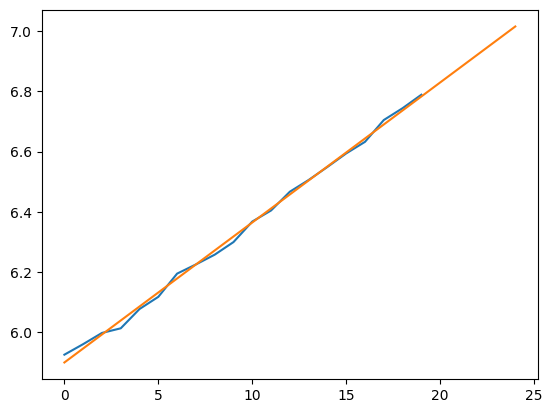

the slope is estimated to be 0.042288763732887674
the intercept is estimated to be 5.794580998943106


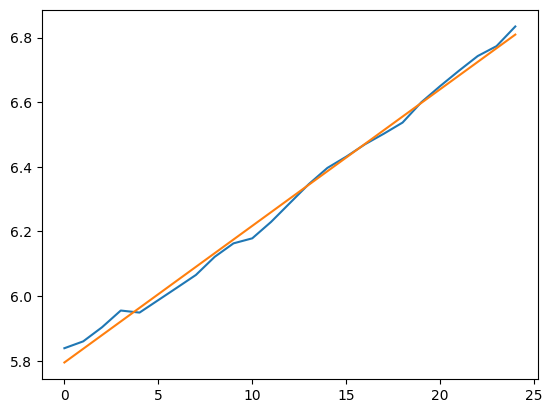

the slope is estimated to be 0.044357920867289735
the intercept is estimated to be 5.7942244545885835


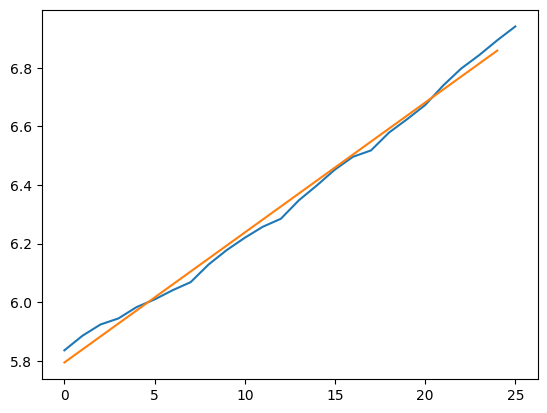

the slope is estimated to be 0.04680412063876564
the intercept is estimated to be 5.9681820255421805


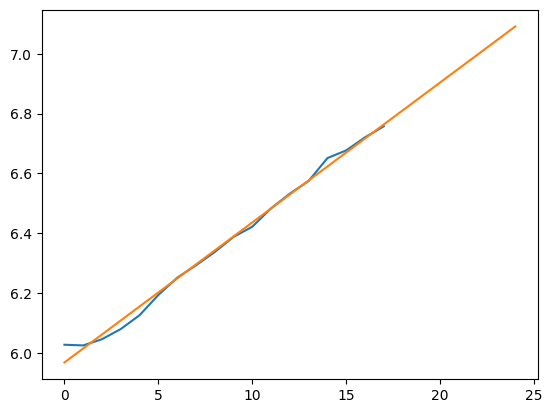

the slope is estimated to be 0.04253683696151263
the intercept is estimated to be 5.778956391545371


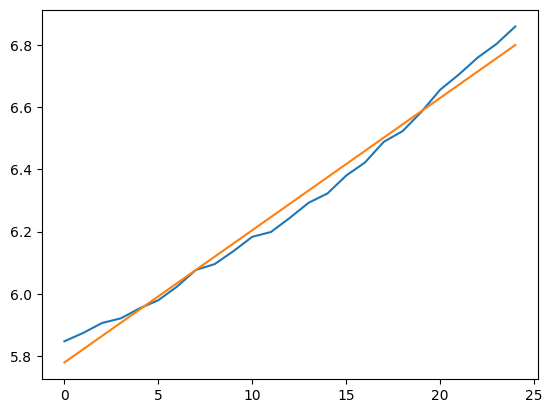

the slope is estimated to be 0.0442600345685557
the intercept is estimated to be 5.9278649719770415


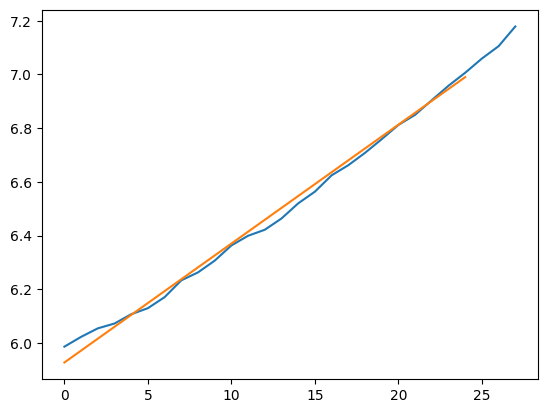

the slope is estimated to be 0.04510972783754527
the intercept is estimated to be 6.274343829904157


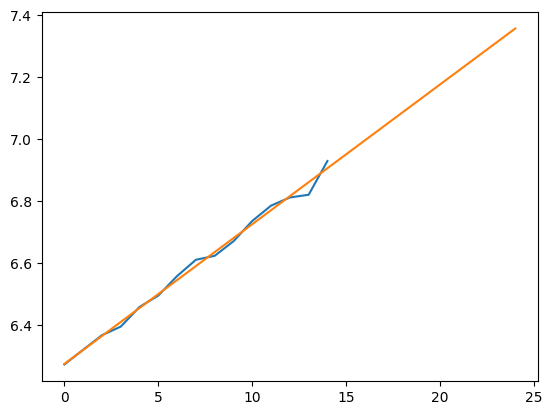

the slope is estimated to be 0.0304210702910231
the intercept is estimated to be 6.031673974486407


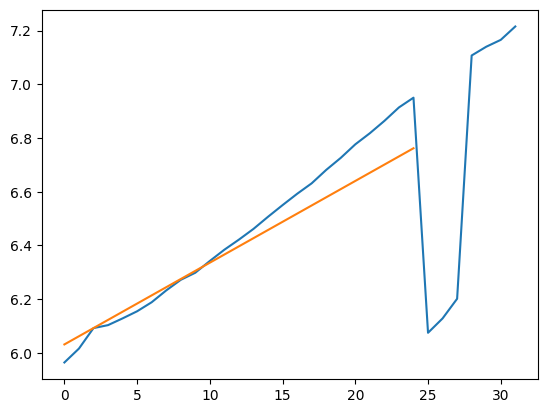

the slope is estimated to be 0.04155077024515374
the intercept is estimated to be 6.314186538115432


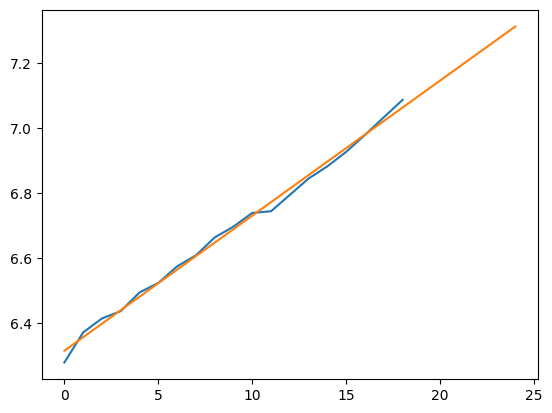

the slope is estimated to be 0.04461870611575133
the intercept is estimated to be 6.176326750920046


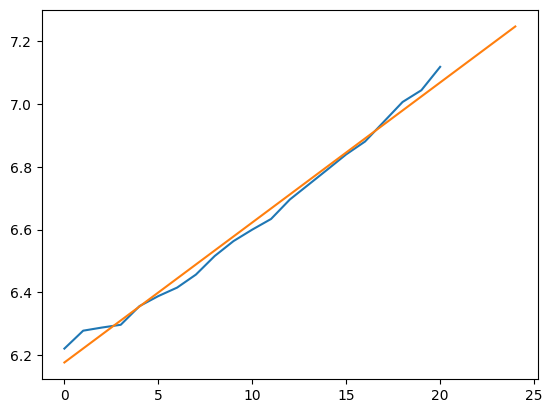

In [9]:
# since we are interested in  exponential growth, slice it according to the data
# in this case data between every peaks can be used
e_phase_idx1 = idx1[:]

exp.collect_model_para(mcell1, e_phase_idx1, plot=True)

In [10]:
print(exp.div_intervals)
print(exp.growth_taus)
print(exp.length_at_div)

[21.0, 20.0, 25.0, 26.0, 18.0, 25.0, 28.0, 15.0, 32.0, 19.0, 21.0]
[22.469722242980428, 21.468995610909737, 23.64694334212251, 22.54388800123895, 21.365640169121075, 23.509035260539022, 22.593746474623057, 22.168167442759213, 32.87195323614529, 24.066942540412587, 22.412124578551577]
[[[18.0, 39.0, 59.0, 84.0, 110.0, 128.0, 153.0, 181.0, 196.0, 228.0, 247.0, 268.0], [120.89851379394531, 115.48722839355469, 110.60189056396484, 114.13518524169922, 122.88018798828125, 108.21312713623047, 116.1199722290039, 144.87208557128906, 121.87496185302734, 148.56715393066406, 135.82086181640625, 138.9565887451172]]]


In [11]:
exp.update_model_para(model="unif")


                    The average time interval for division is 22.727272727272727
                    The time constant for exponential growth is (23.55610535449122, 10.257661883985612)
                    The average division length is 124.86897977193196 
                    with variance 188.14183468495938 and skewness 0.7616185447957313
                    The length for adder model is 60.14954514936967 
                    with variance 189.18882077737152 and skewness 0.4206078820895875
                    


For some cases where you might want to set the parameters manually, e.g., mother cells are not representative of the whole population or cells are growing heterogeneously. Use:

`self.div_interval = some value` - used for setting up prior probability

or, 

`self.growth_tau = some value` - used for estimating the growth of the cells length

Tools to select mode of modelling will be developed later

To include the cells' length into our prior, we need to esimate the skewed Normal cdf parameters. This is done in `update_model_para()`, but can also set manually by `self.sizer_length_para = (mean, var)` and `self.adder_length_para = (mean, var)`. 

`update_model_para(self, model="lineage-trench", Bessel=True)` updates the parameters from our current tracking results of the trench. 

`update_model_para(self, model="lineage-all", Bessel=True)` updates the parameters from our current tracking results of all trenches.

Variance can be corrected by Bessel Correction.

The skewed normal cdf is calculated using an estimation discussed in this paper: 
Amsler, C., Papadopoulos, A., and Schmidt, P. (2021). Evaluating the cdf of the skew normal distribution.

$Pr(div | \delta L, L) = \frac{Pr(div, \delta L, L)}{Pr(L)Pr(\delta L)}$

Since sizer and adder model are assumed to be independent, $Pr(div | \delta L, L) \propto Pr(div|\delta L) Pr(div|L)$

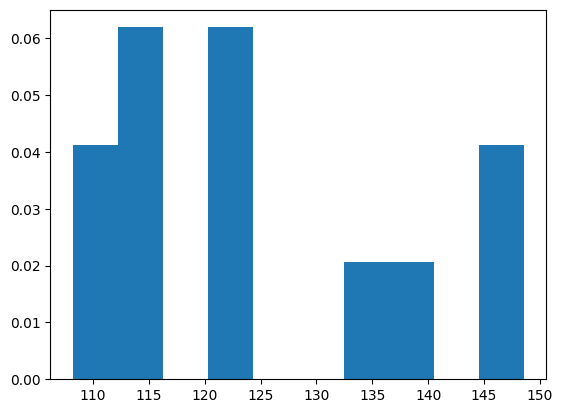

[120.89851379394531, 115.48722839355469, 110.60189056396484, 114.13518524169922, 122.88018798828125, 108.21312713623047, 116.1199722290039, 144.87208557128906, 121.87496185302734, 148.56715393066406, 135.82086181640625, 138.9565887451172]


In [12]:
import matplotlib.pyplot as plt

max_lengths = []
for i in exp.length_at_div:
    max_lengths += i[1]
plt.hist(max_lengths, density=True)
plt.show()
print(max_lengths)

In [13]:
exp.sizer_length_paras

(124.86897977193196, 188.14183468495938)

In [14]:
# In case of a big experiment
import sys

sys.setrecursionlimit(999999999)

#### STEP 2:
For each frame in each trench, look at the current frame in the trench and predict a list of furture of the cells in the next frame with some probability (prior) by using the model from above: growth and division. 

Score each furture with a likelihood function, using y position and length. Select the one with the highest value of prior x likelihood. 

$$\textbf{a priori: }p(y=k|\boldsymbol{\theta}) = \pi_k = (\boldsymbol{\Phi}(\boldsymbol L, \boldsymbol{\delta L} | \boldsymbol{\Theta}) \cdot \boldsymbol{div} + (\boldsymbol 1 - \boldsymbol{\Phi}(\boldsymbol L, \boldsymbol{\delta L} | \boldsymbol{\Theta})) \cdot (\boldsymbol 1 - \boldsymbol{div}))$$
$$\textbf{likelihood: }p(x|y=k, \theta) = \frac{e^{1/(d_{k, min})} - 1}{\sum_j e^{1/(d_{j, min})} - 1}$$
$$\textbf{score/posterior: } p(y=k|x, \boldsymbol{\theta}) \propto (3 + \pi_k) (e^{1/(d_{k, min})} - 1)$$

posterior is also returned as the confidence of the results

**Interested cell's properties**
- Label: only consider the several cells at the top of the trench, the order is consistent
- Major axis length: relevant to cell growth, cell division
- Centroid y coordinates: relevant to cell growth and also the growth of all the previous cells
- Area: relevant to cell growth, cell division
- Zernike moments: desctiptor of cell shape

Since they are geometrical properties, I have decided to not normalise the features.

Run `track_trench` for specified trench, this function can have the following arguments:
- `trench` is the trench_id the track the cells
- `threshold` is the limit of the centroid y axis - this is to limit the number of cells to look at in each trench
- `max_dpf` is the maximum division per frame to simulate, 1 or 2 should be enough but in principle this value can go up to the total number of cells below the threshold, i.e. all cells divide. If it goes over the total number of cells it will instead use the total number.
- `search_mode` is to select the method used to search the cells' matching future, options are simple nearest neighbour 'KDTree' or sequence matching 'SeqMatch' (exclusively one-to-one matching, suggested)
- `probability_mode` can be just "sizer" or "sizer-adder"
- `p_sp` is the probability of all cells entering stationary phase (stop growing), default 0
- `special_reporter` is the channel that you might want to have a slightly easier access in the cell and lineage objects by just Cell.reporter_intensity attribute. (the other channel are inside Cell.channel_intensity list)
- `show_details` will display details of the simulation if set to True, default False
- `ret_df` will return a pandas dataframe rather than a dictionary if set to True, default False
- `fill_gap` normally set to False, but can be set to True when you see some gravity effect at low time resolution: cells fill the gap between them very quickly.
- `adap_dpf` if set to True, automatically add the difference of cell numbers across frames to the max_dpf.
- `skew_model` if set to True, it uses skewed normal cdf for prior calculation.
- `update_para` if set to True, update the model parameters from this tracking result.
- `cumulative` this is an option when the trench is tracked iteratively (start from small threshould to larger). If set to True, the previous tracking results will be reused in the next tracking. (faster and more accurate)
- `radius` coefficient used for Zernike moments, setting to 0 to not use it

In [15]:
print(exp.max_y)

253.01515


In [16]:
track_df, lysis_df = exp.track_trench(trench=0, threshold=-1, max_dpf=3, show_details=False, 
                                      ret_df=True, cumulative=False, radius=0.5)

Tracking over frames in trench 0: 100%|█████████████████████| 299/299 [00:59<00:00,  5.04it/s]


Given that the number of simulations scales exponentially with the number of cells that we need to track simultaneously, and the simulation noise increases proportionally to the number of cells (as positional changes accumulate in one direction), we choose to concurrently track only a restricted number of cells and retain the lineage results for larger and larger threshold. This strategy allows us to track more new cells in the subsequent iterations, with updated parameters and remembered lineages. This significantly improves both the efficiency and the precision of the algorithm.

`exp.track_trenches_iteratively([1,2,3], threshold=-1, max_dpf=2, search_mode="SeqMatch", p_sp=0, special_reporter=None, show_details=False, save_dir="./temp/", ret_df=False, thresh_per_iter=200)`

For tracking multiple trenches (parallel workers):
the additional `save_dir` argument is the directory to save the csv files containing the tracking output, default "./temp/"

The new important parameter is thresh_per_iter, this need to be set carefully so that the appropriate number of cells can be tracking in each iteration. 

In [18]:
# for example, to track multiple trenches
# exp.track_trenches_iteratively([trench for trench in range(0, 10)],
#                                threshold=600, max_dpf=4, search_mode="SeqMatch", 
#                                p_sp=0, special_reporter=None, show_details=False, 
#                                save_dir=exp_dir + "/tracked_trenches/", 
#                                ret_df=False, skew_model=True, thresh_per_iter=600, radius=1)

#### Results:
The results are stored as a new set of Pandas DataFrame, containing all the cells that are below the threshold specified earlier. The colume parent_label shows the label of this cell in the previous frame. 

None means they are not matched. 

There is also a new DataFrame containing all the cells that is considered to be lysed or pushed out of the interested area of the trench, i.e., not matched in the algorithm.

In [19]:
# display(HTML(track_df.to_html()))
# display(HTML(lysis_df.to_html()))

The tracking result can also be extracted from the dictionary `exp.all_cells`, where the key is the `trench_id` and the values is a list of all cell objects overtime with pointers connecting each other indicating their lineages:

`self.all_cells` contains dictionary of trench_id:list for all cells (Object Cell which has attributes such as `Cell.parent` - points to the parent Cell object; `Cell.divide` - bool for whether the cell divides in the next frame, ect.)

Use `pickle` to serialise and save in a file.

In [20]:
# print("In trench 1:")
# for cells in exp.all_cells[1]:
#     for cell in cells:
#         print(f"Cell: {cell}")
#         print(f"Divide?: {cell.divide}")
#         print(f"Parent: {cell.parent}")
#         print(f"Daughters: {cell.daughters}")
#         print(f"Barcode: {cell.barcode}\n")

These Cell objects can be collected into Lineage objects that represent paths of each cells.

`generate_lineage(self, trench, mode="full", frame=None, label=None)`

mode can be "full" (all the cells), "footprint" (the previous path of the specified cell by its frame and label) and "offspring" (all the future offsprings of the specified cell by its frame and label)

#### Tracking visualisations
It is time to visualise our results: first entry is the FOV

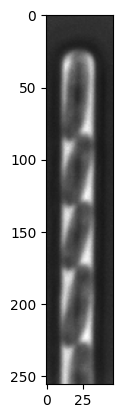

In [27]:
import zarr
import cv2 as cv

image2 = zarr.open(channel_image_dir, mode='r')[0, 0, 0, :, :].astype('uint8')
image2 = cv.cvtColor(image2, cv.COLOR_GRAY2RGB) # comment out if labelled masks

plt.imshow(image2, 'gray')

In [29]:
vis = Visualiser(track_df, lysis_df)

Change the directory and template according to the filename and path of the masks
There are different ways to show the results, more ways might be developed. Currently there are two:
- `mode="connect_daughter"` will connect the daughters with a line when any cell divides
- `mode="landscape-line"` will concatenate the masks given range of frames for one trench and link the cells between frames
- `mode="barcode"` will label the cells with their unique binary barcodes and shade them in grayscale
- `mode="landscape-colour-scale"` will concatenate the masks given range of frames for one trench and label the cells with their unique binary barcodes
- `mode="generation-by-poles"` will label the cells with their poles age to represent generations

Can see more information about this visualiser in a seperate Jupyter Notebook

In [30]:
vis.label_images(channel_image_dir, channel=0, mode="landscape-line", 
                 save_dir=exp_dir + "/labelled_kymo_1010/")

trench 0: 100%|████████████████████████████████████████████| 299/299 [00:00<00:00, 349.99it/s]


saved as /home/rl627/repo/MMLineageTracking/labelled_kymo_1010//landscape_line_TR0_C0.png


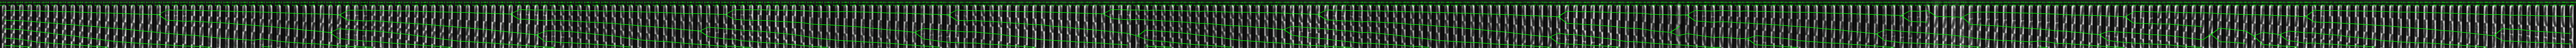

In [33]:
directory = exp_dir + "/labelled_kymo_1010/"
files = [f for f in os.listdir(directory)if os.path.isfile(os.path.join(directory, f))]
display(Image(directory+files[0], unconfined=True))

#### Save results
the `exp.all_cells` is particularly useful, so you might want to save that

In [ ]:
track_df.to_csv(exp_dir + f'/track_results/track_TR_{trench_num}.csv')
lysis_df.to_csv(exp_dir + f'/track_results/lysis_TR_{trench_num}.csv')
with open(exp_dir + f'/track_results/all_cells_track.pickle', 'wb') as handle:
    pickle.dump(exp.all_cells, handle, protocol=pickle.HIGHEST_PROTOCOL)